# Twitter Analysis of Social Distancing
In this project we will use the spacy and sklearn libraries to do some n_gram analysis along with some sentiment analysis of Twitter regarding social distancing. Due to the limitations of the twitter API, we have chosen a relatively small sample size to use for this purpose.
    
The code, along with the files necessary and versions of packages in this instance can be found on this repo: https://github.com/Benjamin-Siebold/MSDS-682-Text-Analytics

In [152]:
from afinn import Afinn
import spacy
import nltk
#nlp = spacy.load('en_core_web_lg')

from wordcloud import WordCloud
from PIL import Image

import pandas as pd
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

### 1 - Dig into data
The first step in this analysis is to load the data into jupyter, and get a general understanding of the data to see if there are any duplicate rows, and duplicate tweets from retweets.

In [2]:
tweets = pd.read_json('tweet_text.json',lines=True)

In [8]:
tweets['id'].nunique()

2476

In [11]:
tweets

,contributors,coordinates,created_at,entities,extended_entities,favorite_count,favorited,geo,id,id_str,...,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,text,truncated,user
0,NaN,None,2020-06-14 17:36:40,"{'hashtags': [], 'symbols': [], 'user_mentions...",None,0,False,None,1272221432769130498,1272221432769130496,...,None,NaN,NaN,31,False,{'created_at': 'Sun Jun 14 08:28:40 +0000 2020...,"<a href=""http://twitter.com/#!/download/ipad"" ...",RT @PFEW_Chair: Worth remembering that there w...,False,"{'id': 143725660, 'id_str': '143725660', 'name..."
1,NaN,None,2020-06-14 17:36:39,"{'hashtags': [], 'symbols': [], 'user_mentions...",None,0,False,None,1272221428331565057,1272221428331565056,...,None,NaN,NaN,13658,False,{'created_at': 'Sun Jun 14 01:09:03 +0000 2020...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",RT @WajahatAli: We've been in lockdown since l...,False,"{'id': 18715514, 'id_str': '18715514', 'name':..."
2,NaN,None,2020-06-14 17:36:39,"{'hashtags': [], 'symbols': [], 'user_mentions...",None,0,False,None,1272221427597561857,1272221427597561856,...,None,NaN,NaN,0,False,None,"<a href=""https://mobile.twitter.com"" rel=""nofo...","Cuomo threatens Manhattan, Hamptons shutdown o...",True,"{'id': 3059518168, 'id_str': '3059518168', 'na..."
3,NaN,None,2020-06-14 17:36:38,"{'hashtags': [], 'symbols': [], 'user_mentions...",None,0,False,None,1272221423868637186,1272221423868637184,...,None,1.271909e+18,1.271909e+18,28482,False,{'created_at': 'Sat Jun 13 21:13:45 +0000 2020...,"<a href=""http://twitter.com/download/iphone"" r...",RT @roywoodjr: Live sports is the reward for c...,False,"{'id': 790366924974632960, 'id_str': '79036692..."
4,NaN,None,2020-06-14 17:36:37,"{'hashtags': [], 'symbols': [], 'user_mentions...",None,0,False,None,1272221419271831552,1272221419271831552,...,None,NaN,NaN,0,False,None,"<a href=""http://twitter.com/download/iphone"" r...",@NYGovCuomo What about a protesters not social...,False,"{'id': 825809169815130112, 'id_str': '82580916..."
5,NaN,None,2020-06-14 17:36:37,"{'hashtags': [], 'symbols': [], 'user_mentions...",None,0,False,None,1272221418420346882,1272221418420346880,...,None,1.271795e+18,1.271795e+18,1888,False,{'created_at': 'Sat Jun 13 14:05:35 +0000 2020...,"<a href=""http://twitter.com/download/iphone"" r...",RT @JaniceDean: Where was your mask yesterday?...,False,"{'id': 1182636458387136512, 'id_str': '1182636..."
6,NaN,None,2020-06-14 17:36:37,"{'hashtags': [], 'symbols': [], 'user_mentions...",None,0,False,None,1272221418013384704,1272221418013384704,...,None,NaN,NaN,6,False,{'created_at': 'Sun Jun 14 14:02:11 +0000 2020...,"<a href=""http://twitter.com/download/android"" ...",RT @RohitJamdade13: @HRDMinistry @drharshvardh...,False,"{'id': 1270373920118628352, 'id_str': '1270373..."
7,NaN,None,2020-06-14 17:36:36,"{'hashtags': [], 'symbols': [], 'user_mentions...",None,0,False,None,1272221415815688192,1272221415815688192,...,None,NaN,NaN,550,False,{'created_at': 'Sun Jun 14 16:48:27 +0000 2020...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",RT @NYGovCuomo: The violation complaints are p...,False,"{'id': 36923320, 'id_str': '36923320', 'name':..."
8,NaN,None,2020-06-14 17:36:35,"{'hashtags': [], 'symbols': [], 'user_mentions...",None,0,False,None,1272221411801612288,1272221411801612288,...,None,1.272201e+18,1.272201e+18,187,False,{'created_at': 'Sun Jun 14 16:40:12 +0000 2020...,"<a href=""http://twitter.com/download/iphone"" r...",RT @imprayassharma: Hey Shaheen bhag !\nThis i...,False,"{'id': 731909264810315777, 'id_str': '73190926..."
9,NaN,None,2020-06-14 17:36:35,"{'hashtags': [], 'symbols': [], 'user_mentions...",None,0,False,None,1272221411516444673,1272221411516444672,...,None,NaN,NaN,2777,False,{'created_at': 'Sun Jun 14 15:12:04 +0000 2020...,"<a href=""http://twitter.com/download/iphone"" r...",RT @Kehlani: people said fuck social distancin...,False,"{'id': 1421516935, 'id_str': '1421516935', 'na..."


In [111]:
tweet_text = pd.DataFrame(tweets['text'])
tweet_text.count()

text    2500
dtype: int64

In [26]:
unique_tweets = pd.DataFrame(tweets['text'].unique(), columns=['tweets'])
unique_tweets.count()

tweets    1054
dtype: int64

In [43]:
joined_tweets = ' '.join(unique_tweets['text'].to_list())

### 2 - Apply n_gram analysis
Now that the data has been investigated, we see that although all of the tweets are unique in ids, there are less than half of unique tweets, which is due to retweets. In the tweet collection, we had the type set to recent, which was getting the most recent tweets. Conclusions could be made that a few individuals were influencers and had a larger following retweeting their tweets causing the retweet spam. The next step is to create an n_gram of both two and three, along with a wordcloud and sorted dictionary.

In [142]:
vectorizer_2 = CountVectorizer(ngram_range = (2,2))
vectorizer_3 = CountVectorizer(ngram_range = (3,3))

In [149]:
ngram_2_counts = vectorizer_2.fit_transform([joined_tweets])
tweets_2_counts = np.array(ngram_2_counts.todense()).flatten()
ngram_3_counts = vectorizer_3.fit_transform([joined_tweets])
tweets_3_counts = np.array(ngram_3_counts.todense()).flatten()

In [150]:
tweets_frequency = {}
for v, i in vectorizer_2.vocabulary_.items():
    tweets_frequency[v] = tweets_2_counts[i]
tf3 = {}
for v, i in vectorizer_3.vocabulary_.items():
    tf3[v] = tweets_3_counts[i]

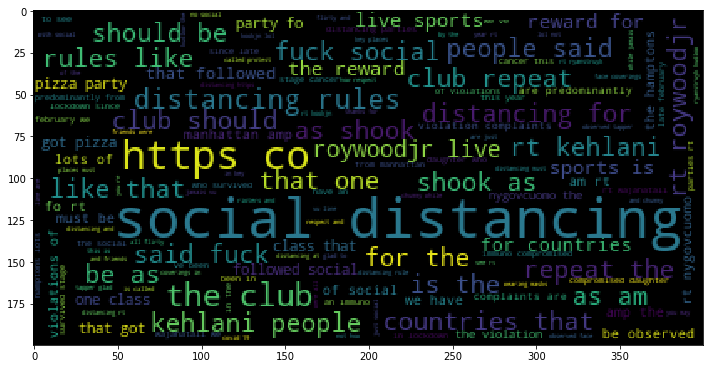

In [52]:
fig = plt.figure(figsize=(12, 12))
wc = WordCloud()
plt.imshow(wc.generate_from_frequencies(tweets_frequency))

In [155]:
sorted_tf_3 = OrderedDict(sorted(tf3.items(), key=lambda kv: kv[1],  reverse=True))
sorted_tf_3

OrderedDict([('social distancing rules', 280),
             ('social distancing for', 229),
             ('fuck social distancing', 227),
             ('said fuck social', 225),
             ('rt kehlani people', 223),
             ('kehlani people said', 223),
             ('people said fuck', 223),
             ('distancing for the', 223),
             ('for the club', 223),
             ('the club repeat', 223),
             ('club repeat the', 223),
             ('repeat the club', 223),
             ('the club should', 223),
             ('club should be', 223),
             ('should be as', 223),
             ('be as shook', 223),
             ('as shook as', 223),
             ('shook as am', 223),
             ('distancing rules like', 213),
             ('rt roywoodjr live', 212),
             ('roywoodjr live sports', 212),
             ('live sports is', 212),
             ('sports is the', 212),
             ('is the reward', 212),
             ('the reward for', 212),
    

### 3 - Setniment Analysis
From above, we can see social distancing is the most common two gram combo, and in the three grame we see a lot of negative connotation around the social distancing, along with who one of the prodominant retweets were coming from. "social distancing rules" and  "fuck social distancing" both indicate people are not in favor of the social distancing, and "rt kehlani people" tells us many of the retweets were the same tweet.


The next step in the analysis is to do sentiment analysis both of the population of tweets, as well as removing retweets to get individual thoughts.

In [64]:
afinn = Afinn()

In [65]:
afinn.score(joined_tweets)

-921.0

In [67]:
afinn.score(' '.join(unique_tweets['tweets'].to_list()))

-169.0

In [102]:
scores = []
for tweet in tweet_text['text']:
    scores.append(afinn.score(tweet))

In [120]:
tweet_score = {'tweets': tweet_text['text'].to_list(), 'score': scores}
tweet_scores_df = pd.DataFrame(tweet_score)

In [104]:
tweet_scores_df.mean()

score   -0.3684
dtype: float64

In [122]:
score_count = tweet_scores_df.groupby(['tweets']).count().sort_values(by='score', ascending=False)

In [107]:
unique_tweet_score = {'tweets': unique_tweets['tweets'].to_list(), 'score': unique_scores}
unique_tweet_scores_df = pd.DataFrame(unique_tweet_score).sort_values(by='score')

In [108]:
unique_tweet_scores_df.mean()

score   -0.160342
dtype: float64

In [125]:
pd.merge(score_count, unique_tweet_scores_df, on='tweets').sort_values(by='score_y')

,tweets,score_x,score_y
50,RT @jack_naylor16: Anti protesters (i.e. Racis...,4,-12.0
142,RT @Francis_Hoar: No lockdown. No masks. No ‘s...,2,-12.0
545,RT @shawngorlando: Reminder.\n\nPeople go to w...,1,-10.0
740,"@LewdSpeedy Social distancing is boring, he li...",1,-9.0
82,RT @JolyonRubs: Last Saturday: \n“Social dista...,3,-9.0
55,RT @Johnhodg10: OMG she actually said the prev...,4,-8.0
325,WTF is happening to our country?! \nWhat the H...,1,-8.0
243,RT @Majid_PSF: The wrong decisions of incompet...,1,-8.0
286,RT @SalmonKromeDome: Purveyors of anti-racism ...,1,-8.0
1039,Go to hell Commi RT @NYGovCuomo: The violatio...,1,-8.0


In [158]:
no_RT = tweets[~tweets['text'].astype(str).str.startswith('RT')]
no_RT['text']

2       Cuomo threatens Manhattan, Hamptons shutdown o...
4       @NYGovCuomo What about a protesters not social...
11             Social Distancing. https://t.co/Z0lCqbvjea
14      @DHSCgovuk @PHE_uk Face coverings should be wo...
24      @jkwan_md @HeatherChwasti Exactly. How much? I...
25      @mullymt @corinne_perkins @ComfortablySmug @Je...
30      @letusgraduate Thanks for the tag. Check the B...
31      Social distancing should have been a thing way...
46      @NYGovCuomo Get off your power trip...there we...
51      Well said! I fear their solution to this will ...
63      Getting closer! Keep social distancing, wearin...
64      It’s all so “not surprising” that in today’s w...
65      @IngrahamAngle The WHO said social distancing ...
66      @Shaheensloan98 @wendymo94921768 @julesserkin ...
67      @rukiakuchiki50 No, that would violate social ...
77           @ErebusRC Social distancing off to an art 👌🏼
81      i’ll also be social distancing more than 6 fee...
84      @ottaw

In [130]:
afinn.score(' '.join(no_RT['text'].to_list()))

-183.0

In [140]:
no_RT_scores = []
for tweet in no_RT['text']:
    no_RT_scores.append(afinn.score(tweet))

In [141]:
no_RT_score = {'tweets': no_RT['text'].to_list(), 'score': no_RT_scores}
no_RT_score_df = pd.DataFrame(no_RT_score).sort_values(by='score')
no_RT_score_df.mean()

score   -0.316062
dtype: float64

### Sentiment Summary
From above we can see when the population is looked at, the overall sentiment score of the entire text is 9 times worse than that of the unique tweets. This is most likely the cause of many retweets causing inflation in the negative direction, the mean sentiment of tweets are also quite a bit different from eachother. What is interesting is when retweets are completely taken out, the mean sentiment of the tweets falls more in line with the total population analysis, and not the unique tweets. This directly contradicts the total sentiment scores of the tweets. What could be the cause of this is unique tweets include the retweets a single time, thus if there are positive retweets that are included they could cause a shift; however, the no retweets suggests the general mentality towards social distancing is negative. 